In [1]:
%matplotlib inline

# Transfer Learning
In this assignment, we will use the weights of a network pre-trained in a particular problem as starting point to train our CNN to a different problem. As training a network from scratch is time-consuming and demands a lot of data, this is a frequent strategy, specially if both datasets (the one used for pre-training and the target) shares similar structures/elements/concepts. 

This is specially true when working with images. Most filters learned in initial convolutional layers will detect low-level elements, such as borders, corners and color blobs, which are common to most problems in the image domain. 

In this notebook, we will load the SqueezeNet architecture trained in the ImageNet dataset and fine-tune it to CIFAR-10.

## Imports

In [2]:
import os
import numpy as np
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras import regularizers
from keras import optimizers
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array
from keras.datasets import cifar10
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
if (sklearn.__version__ == '0.20.0'):
    from sklearn.model_selection import StratifiedShuffleSplit
else:
    from sklearn.cross_validation import StratifiedShuffleSplit


#======================================
# Global definitions
#======================================
n_epochs         = 100
learning_rate    = 1e-3
n_calsses        = 10
train_batch_size = 32
val_batch_size   = 10
    
#Utility to plot
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

The scikit-learn version is 0.17.


Using TensorFlow backend.


## SqueezeNet definition
These methods define our architecture and load the weights obtained using ImageNet data.

In [3]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The class are **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck**.

In [4]:
#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()
print("Train/Val data. X: ", trainVal_data.shape, ", Y: ", trainVal_label.shape)
print("Test data. X: ", X_test.shape, ", Y: ", y_test.shape)

#=====================================
# Prepare the data
#=====================================

#--- Dividing the data into training and validation
folds = 5
if (sklearn.__version__ == '0.20.0'):
    sss = StratifiedShuffleSplit(folds, test_size=0.2, random_state=42)
    sss = sss.split(trainVal_data,trainVal_label)
else:
    sss = StratifiedShuffleSplit(trainVal_label, folds, test_size=0.2, random_state=42)
X_train = []
y_train = []
X_val = []
y_val = []
for train_index, val_index in sss:
    X_train.append(trainVal_data[train_index])
    X_val.append(trainVal_data[val_index])
    y_train.append(trainVal_label[train_index])
    y_val.append(trainVal_label[val_index])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
    
print("--- Splitting data into train and val")
print("Train data. X:",X_train.shape,"Y:",y_train.shape)
print("Val data. X:",X_val.shape,"Y:",y_val.shape)

#--- Data augmentation
aug = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
                         rotation_range=20, 
                         width_shift_range=0.2, height_shift_range=0.2, 
                         horizontal_flip=True, vertical_flip=True, 
                         fill_mode='nearest')

Train/Val data. X:  (50000, 32, 32, 3) , Y:  (50000, 1)
Test data. X:  (10000, 32, 32, 3) , Y:  (10000, 1)
--- Splitting data into train and val
Train data. X: (5, 40000, 32, 32, 3) Y: (5, 40000, 1)
Val data. X: (5, 10000, 32, 32, 3) Y: (5, 10000, 1)


[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


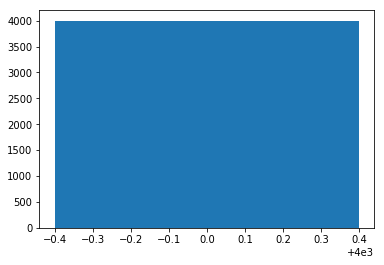

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


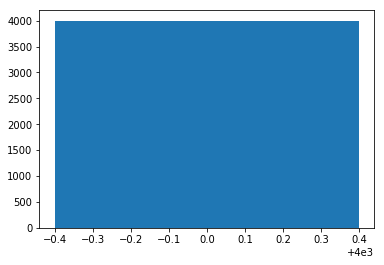

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


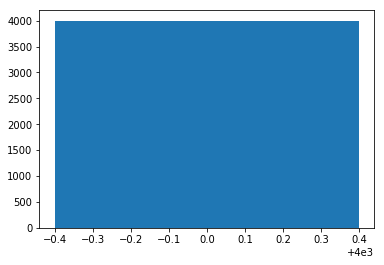

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


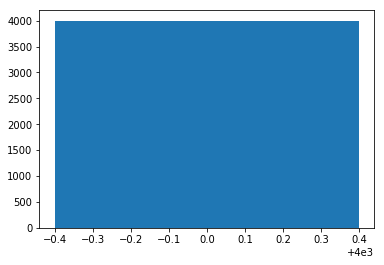

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


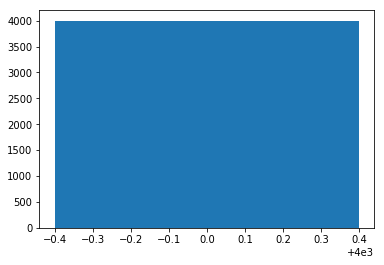

<Figure size 432x288 with 0 Axes>

In [5]:
# Cheking if the splits are balanced
for i in range(folds):
    hist = np.histogram(np.squeeze(y_train[i]))[0]
    print(hist)    
    plt.bar(hist,np.amax(hist),alpha=0.5)
    plt.show()
    plt.clf()

-----------------
## SqueezeNet with frozen layers
Our initial attempt will be to remove SqueezeNet's top layers --- responsible for the classification into ImageNet classes --- and train a new set of layers to our CIFAR-10 classes. We will also freeze the layers before `drop9`. Our architecture will be like this:

<img src="frozenSqueezeNet.png" width=70% height=70%>

In [6]:
#=====================================
# Freezing layers
#=====================================

squeezeNetModel = SqueezeNet((32,32,3))

#freeze layers
for layer in squeezeNetModel.layers:
    layer.trainable = False

#=====================================
# Add new classification layers
#=====================================

#--- Removing layers until drop 9
squeezeNetModel.summary()
squeezeNetModel.layers.pop() #Convolution2D
squeezeNetModel.layers.pop() #Activation ReLU
squeezeNetModel.layers.pop() #Global Avg Pool
squeezeNetModel.layers.pop() #Activation Softmax
squeezeNetModel.summary()

#--- Adding classification layer for 10 classes
out = Convolution2D(n_calsses, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
out = Activation('relu', name='relu_conv10')(out)

out = GlobalAveragePooling2D()(out)
out = Activation('softmax', name='loss')(out)

#=====================================
# New Model
#=====================================
model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')
model.summary()

#--- Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 7, 7, 64)     0           relu_conv1[0][0]                 
_____________________________________

Now, we compile our model and train it:

In [ ]:
#=====================================
# Compile model
#=====================================

#--- Compile the model
# It means to configure the model for training.
# Other types of optimizer:
#    optimizers.Adam(lr=learning_rate)
opt = optimizer=optimizers.SGD(lr=learning_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_calsses)
y_val_categorical = to_categorical(y_val, num_classes=n_calsses)

scores = []
model.save_weights("temp.h5")
for i in range(folds):
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("Optimizer:",opt)
    print("================================================")
    # Training with data augmentation
    '''
    aug.fit(X_train[i])
    model.fit_generator(aug.flow(X_train[i],y_train_categorical[i], batch_size=train_batch_size),
                        steps_per_epoch=X_train.shape[1]//train_batch_size,
                        epochs=n_epochs, 
                        verbose=1)
    '''
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size,
              epochs=n_epochs, 
              verbose=1)
    #--- Evaluating the model for split i
    score = score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    model.load_weights("temp.h5") #avoid overfitting
    
#--- Showing scores
print(scores)

Split: 0
Number of Epochs: 100
Train shape: (40000, 32, 32, 3)
Train batch size: 32
Val batch size: 10
Optimizer: <keras.optimizers.SGD object at 0x7fdcb068b8d0>
Epoch 1/100
40000/40000 [==============================] - 4s 108us/step - loss: 2.5759 - acc: 0.1014
Epoch 2/100
40000/40000 [==============================] - 3s 84us/step - loss: 2.3132 - acc: 0.1019
Epoch 3/100
40000/40000 [==============================] - 3s 86us/step - loss: 2.3072 - acc: 0.1018
Epoch 4/100
40000/40000 [==============================] - 3s 85us/step - loss: 2.3062 - acc: 0.1017
Epoch 5/100
40000/40000 [==============================] - 3s 82us/step - loss: 2.3044 - acc: 0.1032
Epoch 6/100
40000/40000 [==============================] - 3s 83us/step - loss: 2.3042 - acc: 0.1031
Epoch 7/100
40000/40000 [==============================] - 4s 88us/step - loss: 2.3014 - acc: 0.1041
Epoch 8/100
40000/40000 [==============================] - 4s 92us/step - loss: 2.3022 - acc: 0.1036
Epoch 9/100
40000/40000 [====

Finally, let's evaluate on our test set:

In [ ]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

-----------------
-----------------

# Training last 2 Fire Modules + classification layers
As we could see, the frozen network performed very poorly. By freezing most layers, we do not allow SqueezeNet to adapt its weights to features present in CIFAR-10.

Let's try to unfreeze the last two fire modules and train once more. The architecture will be:
<img src="partFrozenSqueezeNet.png" width=70% height=70%>

In [ ]:
squeezeNetModel = SqueezeNet((32,32,3))

#print([layer.name for layer in squeezeNetModel.layers])
#print(squeezeNetModel.layers[-19].name)
#print(len(squeezeNetModel.layers))

#=====================================
# Freezing mentioned layers
#=====================================

trainable_layer_index = 19
for i in range(len(squeezeNetModel.layers)-trainable_layer_index):
    squeezeNetModel.layers[i].trainable = False

#--- Check the trainable status of the individual layers
for layer in squeezeNetModel.layers:
    print(layer.name, " ----- ", layer.trainable)

#=====================================
# Add new classification layers
#=====================================

#--- Removing layers until drop 9
squeezeNetModel.layers.pop() #Convolution2D
squeezeNetModel.layers.pop() #Activation ReLU
squeezeNetModel.layers.pop() #Global Avg Pool
squeezeNetModel.layers.pop() #Activation Softmax
squeezeNetModel.summary()

#--- Adding classification layer for 10 classes
out = Convolution2D(n_calsses, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
out = Activation('relu', name='relu_conv10')(out)

out = GlobalAveragePooling2D()(out)
out = Activation('softmax', name='loss')(out)

#=====================================
# New Model
#=====================================
model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')

Now, we compile our model and train it:

In [ ]:
#=====================================
# Compile model
#=====================================

#--- Compile the model
# It means to configure the model for training.
# Other types of optimizer:
#    optimizers.Adam(lr=1e-3)
opt = optimizer=optimizers.SGD(lr=learning_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#=====================================
# Training model and Evaluation
#=====================================

y_train_categorical = to_categorical(y_train, num_classes=n_calsses)
y_val_categorical = to_categorical(y_val, num_classes=n_calsses)

scores = []
model.save_weights("temp.h5")
for i in range(folds):
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("Optimizer:",opt)
    print("================================================")
    # Training with data augmentation
    '''
    aug.fit(X_train[i])
    model.fit_generator(aug.flow(X_train[i],y_train_categorical[i], batch_size=train_batch_size),
                        steps_per_epoch=X_train.shape[1]//train_batch_size,
                        epochs=n_epochs, 
                        verbose=1)
    '''
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size,
              epochs=n_epochs, 
              verbose=1)
    #--- Evaluating the model for split i
    score = score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    model.load_weights("temp.h5") #avoid overfitting
    
#--- Showing scores
print(scores)

Finally, let's evaluate on our test set:

In [ ]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

-----------
-----------
-----------
# Tensorboard

Tensorboard is a visualization tool for Tensorflow. Among other things, it allows us to monitor the progress of our training, plot metrics per epochs, visualize the architecture's schematics. 

Just like for Early Stopping, we will use the [Tensorboard callback](https://keras.io/callbacks/#tensorboard) to log the information about our training. An example of usage, would be:

As your training progresses, Keras will log the metrics (e.g., loss, accuracy) to `<<LOG_DIR>>` (**make sure `<<LOG_DIR>>` is a valid directory)**. On your terminal, you will need to run Tensorboard, assign a port and access it via browser (just like jupyter).

#### ----> MAKE SURE YOU USE A DIFFERENT PORT FOR JUPYTER AND TENSORBOARD <----

### Docker
For those using docker, open a new terminal and create a new container (using the same image) running Tensorboard:

For example:

After starting Tensorboard, access it via browser on `http://localhost:<<port_container>>`.

### Anaconda
$ tensorboard --logdir=<<LOG_DIR>> --port=<<port>>

After starting Tensorboard, access it via browser on `http://localhost:<<port>>`.

-----------
-----------
-----------

# Fine-tuning all layers

What if we fine-tune all layers of SqueezeNet?
<img src="unfrozenSqueezeNet.png" width=70% height=70%>

In [ ]:
squeezeNetModel = SqueezeNet((32,32,3))

for layer in squeezeNetModel.layers:
    layer.trainable = True       #by default they are all trainable, but just for clarification

#=====================================
# Add new classification layers
#=====================================

#--- Removing layers until drop 9
squeezeNetModel.layers.pop() #Convolution2D
squeezeNetModel.layers.pop() #Activation ReLU
squeezeNetModel.layers.pop() #Global Avg Pool
squeezeNetModel.layers.pop() #Activation Softmax

#--- Adding classification layer for 10 classes
out = Convolution2D(n_calsses, (1, 1), padding='valid', name='conv10')(squeezeNetModel.layers[-1].output)
out = Activation('relu', name='relu_conv10')(out)

out = GlobalAveragePooling2D()(out)
out = Activation('softmax', name='loss')(out)

#=====================================
# New Model
#=====================================
model = Model(squeezeNetModel.inputs, out, name='squeezenet_new')

model.summary()

Now, we compile our model and train it:

In [ ]:
from time import time

#=====================================
# Compile model
#=====================================

#--- Compile the model
# It means to configure the model for training.
# Other types of optimizer:
#    optimizers.Adam(lr=learning_rate)
opt = optimizer=optimizers.SGD(lr=learning_rate)
print("--- Compiling model")
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#=====================================
# Tensorboard callback
#=====================================

print("--- Preparing tensorboard")
tbCallBack = TensorBoard(log_dir="logs/{}".format(time()), write_graph=True)

#=====================================
# Training model and Evaluation
#=====================================
print("--- Start training")
y_train_categorical = to_categorical(y_train, num_classes=n_calsses)
y_val_categorical = to_categorical(y_val, num_classes=n_calsses)

scores = []
model.save_weights("temp.h5")
for i in range(folds):
    #--- Evaluating the model for split i
    print("================================================")
    print("Split: "+str(i))
    print("Number of Epochs: "+str(n_epochs))
    print("Train shape:",X_train[i].shape)
    print("Train batch size: "+str(train_batch_size))
    print("Val batch size: "+str(val_batch_size))
    print("Optimizer:", opt)
    print("================================================")
    # Training with data augmentation
    '''
    aug.fit(X_train[i])
    model.fit_generator(aug.flow(X_train[i],y_train_categorical[i], batch_size=train_batch_size),
                        steps_per_epoch=X_train.shape[1]//train_batch_size,
                        epochs=n_epochs, 
                        verbose=1,
                        callbacks=[tbCallBack])
    '''
    # Training without data augmentation
    model.fit(X_train[i],y_train_categorical[i], batch_size=train_batch_size,
              epochs=n_epochs, 
              verbose=1,
              callbacks=[tbCallBack])
    #--- Evaluating the model for split i
    score = model.evaluate(x=X_val[i], y=y_val_categorical[i], batch_size=val_batch_size, verbose=1)
    scores.append(score)
    print('Validation loss:', score[0])
    print('Validation accuracy (NORMALIZED):', score[1])
    model.load_weights("temp.h5")
    
    
#--- Showing scores
print(scores)

Finally, let's evaluate on our validation set:

In [ ]:
#=====================================
# Evaluate on validation
#=====================================

#--- The evaluation of the model 
np_aux = np.array(scores).mean(axis=0)

print('Mean Validation loss:', np_aux[0])
print('Mean Validation accuracy (NORMALIZED):', np_aux[1])

In [ ]:
# Evaluate your best model on test
# ...

## Saving the model
Now that we are working on more complex tasks and our trainings are starting to take more time it is usually a good idea to save the trained model from time to time. [Keras has a lot of ways of saving and loading the model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model), but in this exercise we will use the simplest of them all: `model.save()`. It saves the architecture, the weights, the choice of loss function/optimizer/metrics and even the current state of the training, so you can resume your training later.

In [ ]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

## Loading a model
Once we have our model trained, we can load it using:

In [ ]:
from keras.models import load_model

del model  # Will delete model, only to check if load_model is working

# returns a compiled model identical to the previous one
model = load_model('my_model.h5')

# evaluate test set again... should give us the same result
# ...
print('Test loss:', score[0])
print('Test accuracy (NORMALIZED):', score[1])